In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
def show_scrollable(df, max_rows=20, height=400, return_html=False):
    df = df.sort_values(['SessionId', 'turid'])
    cols = list(df.columns)
    if 'SessionId' in cols and 'turid' in cols:
        session_idx = cols.index('SessionId')
        cols.remove('turid')
        cols.insert(session_idx + 1, 'turid')
        df = df[cols]
    html = df.head(max_rows).to_html(notebook=True)
    full_html = f'<div style="overflow:auto; height:{height}px">{html}</div>'
    if return_html:
        return full_html
    else:
        display(HTML(full_html))

In [3]:
OLD = pd.read_csv("Data/FastCheckTUData.csv", encoding='utf-8')
RAG = pd.read_csv("Data/RAG_corrected_df.csv", encoding='utf-8')

In [4]:
OLD["SessionId"].nunique()

74596

### In the RAG we excluded public transports (transport middel above 20) during the training and the RAG itself, while in DET we emanually exclude them now, as well as in the initial data, to make them equally comparable

In [5]:
# Remove rows where transportmiddel > 25
OLD = OLD[OLD['transportmiddel'] <= 25]
print(f"OLD now has {len(OLD)} rows after removing transportmiddel > 25")

OLD now has 234531 rows after removing transportmiddel > 25


In [6]:
# Also filter RAG to transportmiddel <= 25 for fair comparison
RAG = RAG[RAG['transportmiddel'] <= 25]
print(f"RAG now has {len(RAG)} rows after removing transportmiddel > 25")

RAG now has 234531 rows after removing transportmiddel > 25


## We limit our analysis, in order to remove the hallucinations of the LLM , to rows where the confidence of both Start and End is >= 0.9 , for the RAG method

In [7]:
RAG['rag_start_conf'].describe()

count    234531.000000
mean          0.958979
std           0.072478
min           0.386381
25%           0.933540
50%           1.000000
75%           1.000000
max           1.000001
Name: rag_start_conf, dtype: float64

In [8]:
RAG['rag_start_conf'] = pd.to_numeric(RAG['rag_start_conf'], errors='coerce')
RAG['rag_end_conf'] = pd.to_numeric(RAG['rag_end_conf'], errors='coerce')

RAG = RAG[(RAG['rag_start_conf'] > 0.9) & (RAG['rag_end_conf'] > 0.9)]

In [9]:
print(f"RAG now has {len(RAG)} rows")

RAG now has 161829 rows


In [10]:
show_scrollable(RAG, max_rows=3)

,SessionId,turid,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,tiladrsogeord,tiladrtext_raw,transportmiddel,stagelength_raw,stagedurationmin_raw,home_lat,home_lon,work_lat,work_lon,start_lat,start_lon,til_lat,til_lon,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,prompt_text,rag_start_address,rag_start_lat,rag_start_lon,rag_start_conf,rag_end_address,rag_end_lat,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction
0,347009,2118077,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",NaN,"Bellisvej 38, 2970 Hørsholm",Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",1.0,1.0,10.0,55.882587,12.490543,55.727110,12.584047,55.882587,12.490543,55.888063,12.493051,0.628716,0.000000,0.628716,False,False,False,trusted,"Below is an instruction that describes a task,...","Bellisvej 38, 2970 Hørsholm",55.882587,12.490543,1.0,"Ahornvej 30, 2970 Hørsholm",55.888061,12.493057,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,VALID,NaN,NaN,NaN
1,347009,2118078,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",NaN,"bellisvej 38, 2970 hørsholm",11.0,1.0,3.0,55.882587,12.490543,55.727110,12.584047,55.888063,12.493051,55.882587,12.490543,0.628716,0.628716,0.000000,False,False,False,trusted,"Below is an instruction that describes a task,...","Ahornvej 30, 2970 Hørsholm",55.888061,12.493057,1.0,"Bellisvej 38, 2970 Hørsholm",55.882587,12.490543,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,VALID,NaN,NaN,NaN
2,347010,2118081,"Keilstruplund 83, 3460 Birkerød","Kongens Vænge 2A, 3400 Hillerød","Keilstruplund 83, 3460 Birkerød",NaN,"Keilstruplund 83, 3460 Birkerød",Høsterkøb kirke,"høsterkøb kirke, gøngehusvej 286, 2970 hørsholm",11.0,5.0,10.0,55.839173,12.444784,55.930675,12.348036,55.839173,12.444784,55.851356,12.489082,3.079457,0.000000,3.079457,False,False,False,trusted,"Below is an instruction that describes a task,...","Keilstruplund 83, 3460 Birkerød",55.839170,12.444778,1.0,"Gøngehusvej 286, 2970 Hørsholm",55.851360,12.489075,0.937413,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,VALID,NaN,NaN,NaN


In [11]:
print('Unique SessionId in RAG:', RAG['SessionId'].nunique())

Unique SessionId in RAG: 59017


In [12]:
RAG.columns

Index(['SessionId', 'homeText_raw', 'workText_raw', 'startDayText_raw',
       'startstedadrsogeord', 'startTripText_raw', 'turid', 'tiladrsogeord',
       'tiladrtext_raw', 'transportmiddel', 'stagelength_raw',
       'stagedurationmin_raw', 'home_lat', 'home_lon', 'work_lat', 'work_lon',
       'start_lat', 'start_lon', 'til_lat', 'til_lon', 'calc_dist_geo',
       'dist_start_home', 'dist_end_home', 'flag_coords_bad', 'flag_speed_bad',
       'flag_zero_dist', 'validation_status', 'prompt_text',
       'rag_start_address', 'rag_start_lat', 'rag_start_lon', 'rag_start_conf',
       'rag_end_address', 'rag_end_lat', 'rag_end_lon', 'rag_end_conf',
       'rag_prompt_text', 'llm_full_response', 'llm_verdict',
       'corrected_dist_km', 'corrected_time_min', 'note_correction'],
      dtype='object')

In [13]:
print("RAG llm_verdict counts:")
display(RAG['llm_verdict'].value_counts().to_frame())

RAG llm_verdict counts:


,count
llm_verdict,
VALID,160387
corrected,1437
INVALID,5


In [14]:
RAG['llm_verdict'] = RAG['llm_verdict'].replace('INVALID', 'invalid')
RAG['llm_verdict'] = RAG['llm_verdict'].replace('VALID', 'trusted')

In [15]:
rag_corrected = RAG[RAG['llm_verdict'] == 'corrected']

print(f"rag_corrected has {len(rag_corrected)} rows")

rag_corrected has 1437 rows


In [16]:
show_scrollable(rag_corrected.head(5))

,SessionId,turid,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,tiladrsogeord,tiladrtext_raw,transportmiddel,stagelength_raw,stagedurationmin_raw,home_lat,home_lon,work_lat,work_lon,start_lat,start_lon,til_lat,til_lon,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,prompt_text,rag_start_address,rag_start_lat,rag_start_lon,rag_start_conf,rag_end_address,rag_end_lat,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction
227,347147,2118373,"Kejlstrupvej 15, 8600 Silkeborg",NaN,NaN,NaN,"kejlstrupvej 15, 8600 silkeborg","Nørrevænget 42, 8600","nørrevænget 42, 8600 silkeborg",1.0,1.0,2.0,56.178886,9.554954,NaN,NaN,56.178886,9.554954,56.183815,9.545761,0.789938,0.000000,0.789938,False,True,False,hard_wrong,"Below is an instruction that describes a task,...","Kejlstrupvej 15, 8600 Silkeborg",56.178882,9.554949,1.0,"Nørrevænget 42, 8600 Silkeborg",56.183812,9.545765,1.0,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,1.0,13.0,osrm_recalc
466,347271,2118667,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør","Ydunsvej 9, 3000 Helsingør",NaN,"Ydunsvej 9, 3000 Helsingør",NaN,"sundtoldvej 2, 3000 helsingør",2.0,1.0,1.0,56.039003,12.594531,56.041347,12.606025,56.039003,12.594531,56.041347,12.606025,0.760045,0.000000,0.760045,False,False,False,trusted,"Below is an instruction that describes a task,...","Ydunsvej 9, 3000 Helsingør",56.039002,12.594529,1.0,"Sundtoldvej 2, 3000 Helsingør",56.041346,12.606020,1.0,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,1.0,6.0,osrm_recalc
469,347271,2118670,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør","Ydunsvej 9, 3000 Helsingør",NaN,"ydunsvej 9, 3000 helsingør","Gefionsvej 47, 3000","gefionsvej 47a, 3000 helsingør",2.0,1.0,1.0,56.039003,12.594531,56.041347,12.606025,56.039003,12.594531,56.039490,12.587380,0.447453,0.000000,0.447453,False,False,False,trusted,"Below is an instruction that describes a task,...","Ydunsvej 9, 3000 Helsingør",56.039002,12.594529,1.0,"Gefionsvej 47A, 3000 Helsingør",56.039495,12.587382,1.0,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.6,3.0,osrm_recalc
470,347271,2118671,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør","Ydunsvej 9, 3000 Helsingør","Gefionsvej 47, 3000","gefionsvej 47a, 3000 helsingør",NaN,"ydunsvej 9, 3000 helsingør",2.0,1.0,1.0,56.039003,12.594531,56.041347,12.606025,56.039490,12.587380,56.039003,12.594531,0.447453,0.447453,0.000000,False,False,False,trusted,"Below is an instruction that describes a task,...","Gefionsvej 47A, 3000 Helsingør",56.039495,12.587382,1.0,"Ydunsvej 9, 3000 Helsingør",56.039002,12.594529,1.0,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.7,3.0,osrm_recalc
571,347313,2118798,"Ringstedgade 120, 4700 Næstved","Jagtvej 2A, 4700 Næstved","Ringstedgade 120, 4700 Næstved",NaN,"jagtvej 2a, 4700 næstved",NaN,"ringstedgade 120, 4700 næstved",1.0,15.0,35.0,55.246251,11.761771,55.227441,11.781291,55.227441,11.781291,55.246251,11.761771,2.430264,2.430264,0.000000,False,True,False,hard_wrong,"Below is an instruction that describes a task,...","Jagtvej 2A, 4700 Næstved",55.227437,11.781294,1.0,"Ringstedgade 120, 4700 Næstved",55.246250,11.761763,1.0,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,3.1,38.0,osrm_recalc


In [17]:
rag_zero_dist = RAG[(RAG['flag_zero_dist'] == True) & (RAG['llm_full_response'].str.contains('Speed'))]

print(f"rag_zero_dist has {len(rag_zero_dist)} rows")

rag_zero_dist has 35 rows


In [18]:
show_scrollable(rag_zero_dist)

,SessionId,turid,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,tiladrsogeord,tiladrtext_raw,transportmiddel,stagelength_raw,stagedurationmin_raw,home_lat,home_lon,work_lat,work_lon,start_lat,start_lon,til_lat,til_lon,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,prompt_text,rag_start_address,rag_start_lat,rag_start_lon,rag_start_conf,rag_end_address,rag_end_lat,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction
15528,354178,2138734,"Havnegade 33, 1058 København K",NaN,NaN,NaN,"Havnegade 33, 1058 København K",NaN,"havnegade 33, 1058 københavn k",1.0,3.0,4.0,55.676879,12.589345,NaN,NaN,55.676879,12.589361,55.676879,12.589361,0.0,0.000996,0.000996,False,True,True,hard_wrong,"Below is an instruction that describes a task,...","Havnegade 33, 1058 København K",55.676883,12.589356,1.000000,"Havnegade 33, 1058 København K",55.676883,12.589356,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
21613,356864,2146811,"Grønvangen 123, 5550 Langeskov","Maersk Training Centre A/s, Dyrekredsen 4, 570...","Grønvangen 123, 5550 Langeskov",NaN,"Grønvangen 123, 5550 Langeskov",NaN,"grønvangen 123, 5550 langeskov",1.0,3.0,15.0,55.361526,10.576434,55.035717,10.538592,55.361526,10.576434,55.361526,10.576434,0.0,0.000000,0.000000,False,False,True,trusted,"Below is an instruction that describes a task,...","Grønvangen 123, 5550 Langeskov",55.361526,10.576437,1.000000,"Grønvangen 123, 5550 Langeskov",55.361526,10.576437,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
23534,357826,2149572,"Kæruldvænget 17, Dyrup, 5250 Odense SV","Højmeskolen, Højmevænget 3, Dyrup, 5250 Odense SV","Kæruldvænget 17, Dyrup, 5250 Odense SV",NaN,"Kæruldvænget 17, Dyrup, 5250 Odense SV",NaN,"kæruldvænget 17, dyrup, 5250 odense sv",1.0,2.0,10.0,55.344505,10.338264,55.352125,10.338253,55.344505,10.338264,55.344505,10.338264,0.0,0.000000,0.000000,False,False,True,trusted,"Below is an instruction that describes a task,...","Dyrupgårdvænget 18, 5250 Odense SV",55.353760,10.351146,0.950757,"Dyrupgårdvænget 18, 5250 Odense SV",55.353760,10.351146,0.950757,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
24841,358414,2151437,"Brøndby Nord Vej 82, 2605 Brøndby",NaN,NaN,NaN,"Brøndby Nord Vej 82, 2605 Brøndby",NaN,"brøndby nord vej 82, 2605 brøndby",1.0,2.0,10.0,55.668023,12.431339,NaN,NaN,55.668023,12.431355,55.668023,12.431355,0.0,0.000996,0.000996,False,False,True,trusted,"Below is an instruction that describes a task,...","Brøndby Nord Vej 82, 2605 Brøndby",55.668025,12.431349,1.000000,"Brøndby Nord Vej 82, 2605 Brøndby",55.668025,12.431349,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
25134,358546,2151888,"Egevej 3, 8680 Ry","MØLLESKOLEN, Skanderborgvej 50, 8680 Ry","Egevej 3, 8680 Ry",9900,"egevej 3, 8680 ry",NaN,"egevej 3, 8680 ry",1.0,208.0,1.0,56.083294,9.771135,56.091300,9.762391,56.083302,9.771152,56.083302,9.771152,0.0,0.001411,0.001411,False,True,True,hard_wrong,"Below is an instruction that describes a task,...","Egevej 3, 8680 Ry",56.083299,9.771148,1.000000,"Egevej 3, 8680 Ry",56.083299,9.771148,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
40689,406297,2417558,"Resedavej 51, 8600 Silkeborg","Hejrevej 25, 8600 Silkeborg","Resedavej 51, 8600 Silkeborg",NaN,"Resedavej 51, 8600 Silkeborg",NaN,"resedavej 51, 8600 silkeborg",1.0,2.0,10.0,56.184965,9.553801,56.172596,9.564945,56.184965,9.553801,56.184965,9.553801,0.0,0.000000,0.000000,False,False,True,trusted,"Be

In [19]:
RAG.columns

Index(['SessionId', 'homeText_raw', 'workText_raw', 'startDayText_raw',
       'startstedadrsogeord', 'startTripText_raw', 'turid', 'tiladrsogeord',
       'tiladrtext_raw', 'transportmiddel', 'stagelength_raw',
       'stagedurationmin_raw', 'home_lat', 'home_lon', 'work_lat', 'work_lon',
       'start_lat', 'start_lon', 'til_lat', 'til_lon', 'calc_dist_geo',
       'dist_start_home', 'dist_end_home', 'flag_coords_bad', 'flag_speed_bad',
       'flag_zero_dist', 'validation_status', 'prompt_text',
       'rag_start_address', 'rag_start_lat', 'rag_start_lon', 'rag_start_conf',
       'rag_end_address', 'rag_end_lat', 'rag_end_lon', 'rag_end_conf',
       'rag_prompt_text', 'llm_full_response', 'llm_verdict',
       'corrected_dist_km', 'corrected_time_min', 'note_correction'],
      dtype='object')

## Calculate F-1 score

In [20]:
# Only look at the rows you actually touched (where the LLM intervened)
# We check if 'corrected_dist_km' exists and is not NaN (meaning OSRM succeeded)
df_corrected = RAG[RAG['corrected_dist_km'].notna()].copy()

print(f"--- THESIS RESULTS VALIDATION ---")
print(f"Total Rows Intervened On: {len(df_corrected)}")

# ==============================================================================
# METRIC 1: SPATIAL DATA IMPUTATION (Adding coordinates where they were missing)
# ==============================================================================

# Logic: Original data had bad coords (flag_coords_bad=True) 
# BUT your new RAG columns have valid coords.

# We assume 'rag_start_lat' is your new coordinate source from the RAG process
#
has_bad_original_coords = df_corrected['flag_coords_bad'] == True
has_good_new_coords = (df_corrected['rag_start_lat'].notna()) & (df_corrected['rag_start_lat'] != 0)

# Calculate the "Imputation Rate"
restored_coords_count = df_corrected[has_bad_original_coords & has_good_new_coords].shape[0]

print(f"\n[1] SPATIAL IMPUTATION (Recovering Lost Locations)")
print(f"Trips with originally invalid/missing coordinates: {has_bad_original_coords.sum()}")
print(f"Trips successfully geocoded by your pipeline:      {restored_coords_count}")
print(f"Success Rate: {(restored_coords_count / has_bad_original_coords.sum() * 100):.1f}%")


# ==============================================================================
# METRIC 2: PHYSICAL PLAUSIBILITY (Making results realistic)
# ==============================================================================

# Logic: Original speed was impossible. New speed is possible.

# Helper to calc speed
def get_speed(dist, mins):
    if mins is None or mins <= 0: return 9999 # Avoid div/0, treat as bad
    return (dist / mins) * 60

# 1. Calculate Old vs New Speed
df_corrected['speed_old'] = df_corrected.apply(
    lambda x: get_speed(x['stagelength_raw'], x['stagedurationmin_raw']), axis=1
)
df_corrected['speed_new'] = df_corrected.apply(
    lambda x: get_speed(x['corrected_dist_km'], x['corrected_time_min']), axis=1
)

# 2. Define "Realistic" Thresholds (Matching your prep file logic)
#
def is_realistic(row, speed_col):
    mode = row['transportmiddel']
    speed = row[speed_col]
    
    if mode == 1: return speed <= 15   # Walk
    if mode == 2: return speed <= 60   # Bike
    return speed <= 180                # Car

# Check validity before and after
df_corrected['valid_before'] = df_corrected.apply(lambda x: is_realistic(x, 'speed_old'), axis=1)
df_corrected['valid_after']  = df_corrected.apply(lambda x: is_realistic(x, 'speed_new'), axis=1)

# Count how many WENT from Invalid -> Valid
fixed_physics_count = df_corrected[(~df_corrected['valid_before']) & (df_corrected['valid_after'])].shape[0]

print(f"\n[2] SANITY RESTORATION (Fixing Impossible Physics)")
print(f"Trips that originally violated physical speed limits: {(~df_corrected['valid_before']).sum()}")
print(f"Trips restored to realistic speeds by OSRM:           {fixed_physics_count}")
print(f"Correction Efficacy: {(fixed_physics_count / (~df_corrected['valid_before']).sum() * 100):.1f}%")

# ==============================================================================
# SUMMARY STATS FOR THESIS TEXT
# ==============================================================================
print(f"\n[3] SUMMARY")
print(f"The methodology successfully imputed missing spatial data for {restored_coords_count} trips and corrected physically impossible travel metrics for {fixed_physics_count} trips,")
print(f" resulting in a total dataset enhancement of {len(df_corrected)} usable records that were previously invalid.")

--- THESIS RESULTS VALIDATION ---
Total Rows Intervened On: 1437

[1] SPATIAL IMPUTATION (Recovering Lost Locations)
Trips with originally invalid/missing coordinates: 686
Trips successfully geocoded by your pipeline:      686
Success Rate: 100.0%

[2] SANITY RESTORATION (Fixing Impossible Physics)
Trips that originally violated physical speed limits: 437
Trips restored to realistic speeds by OSRM:           412
Correction Efficacy: 94.3%

[3] SUMMARY
The methodology successfully imputed missing spatial data for 686 trips and corrected physically impossible travel metrics for 412 trips,
 resulting in a total dataset enhancement of 1437 usable records that were previously invalid.


In [21]:
# Calculate differences between raw and corrected values
RAG['dist_delta'] = RAG['stagelength_raw'] - RAG['corrected_dist_km']
RAG['time_delta'] = RAG['stagedurationmin_raw'] - RAG['corrected_time_min']

RAG.head(5)

,SessionId,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,turid,tiladrsogeord,tiladrtext_raw,transportmiddel,...,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction,dist_delta,time_delta
0,347009,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",NaN,"Bellisvej 38, 2970 Hørsholm",2118077,Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",1.0,...,12.493057,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN
1,347009,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",2118078,NaN,"bellisvej 38, 2970 hørsholm",11.0,...,12.490543,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN
2,347010,"Keilstruplund 83, 3460 Birkerød","Kongens Vænge 2A, 3400 Hillerød","Keilstruplund 83, 3460 Birkerød",NaN,"Keilstruplund 83, 3460 Birkerød",2118081,Høsterkøb kirke,"høsterkøb kirke, gøngehusvej 286, 2970 hørsholm",11.0,...,12.489075,0.937413,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN
3,347010,"Keilstruplund 83, 3460 Birkerød","Kongens Vænge 2A, 3400 Hillerød","Keilstruplund 83, 3460 Birkerød",Høsterkøb kirke,"høsterkøb kirke, gøngehusvej 286, 2970 hørsholm",2118082,NaN,"keilstruplund 83, 3460 birkerød",11.0,...,12.444778,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN
8,347016,"Lærkegårdsvænget 5, Ordrup, 4540 Fårevejle","Cargovej 1, 4840 Nørre Alslev","Lærkegårdsvænget 5, Ordrup, 4540 Fårevejle",4534,"Søhusvej 6, Vejleby, 4534 Hørve",2118090,NaN,"lærkegårdsvænget 5, ordrup, 4540 fårevejle",11.0,...,11.421494,0.913498,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN


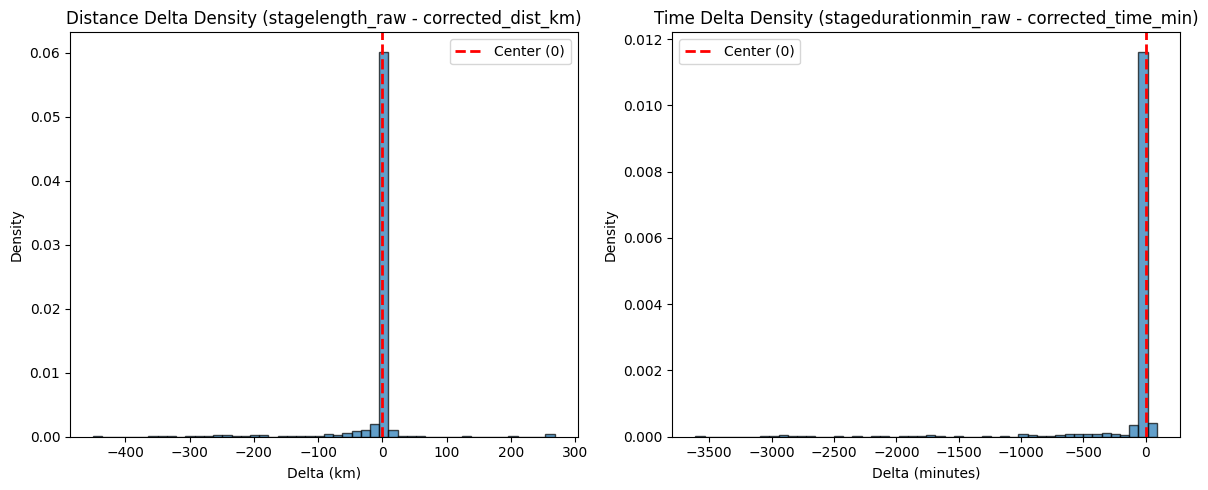

In [22]:
import matplotlib.pyplot as plt

# Plot density histograms for the deltas, highlighting the center (0)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distance delta
dist_delta = RAG['dist_delta'].dropna()
axes[0].hist(dist_delta, bins=50, edgecolor='black', alpha=0.7, density=True)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Center (0)')
axes[0].set_title('Distance Delta Density (stagelength_raw - corrected_dist_km)')
axes[0].set_xlabel('Delta (km)')
axes[0].set_ylabel('Density')
axes[0].legend()

# Time delta
time_delta = RAG['time_delta'].dropna()
axes[1].hist(time_delta, bins=50, edgecolor='black', alpha=0.7, density=True)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Center (0)')
axes[1].set_title('Time Delta Density (stagedurationmin_raw - corrected_time_min)')
axes[1].set_xlabel('Delta (minutes)')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

In [23]:
# 2. Filter for the "Intervention Set"
# CHANGE: Now checking if EITHER distance OR time was corrected/imputed.
# This ensures we capture every row where the pipeline provided new data.
intervention_mask = (RAG['corrected_dist_km'].notna()) | (RAG['corrected_time_min'].notna())
intervention_set = RAG[intervention_mask].copy()

# --- METRIC 1: RECOVERY RATE ---
# We count any row where the LLM flagged it (INVALID or corrected)
total_invalid_flagged = (RAG['llm_verdict'] == 'INVALID').sum() + (RAG['llm_verdict'] == 'corrected').sum()
total_corrected = intervention_set.shape[0]
success_rate = (total_corrected / total_invalid_flagged) * 100

# --- METRIC 2: SPATIAL IMPUTATION (Missing Coords Fixed) ---
# Logic: Originally bad coords -> Now valid coords in the corrected set
bad_coords_mask = intervention_set['flag_coords_bad'] == True
fixed_coords_count = intervention_set[bad_coords_mask].shape[0]

# --- METRIC 3: PHYSICAL PLAUSIBILITY (Speed/Physics Check) ---
def get_speed(dist, mins):
    # Avoid division by zero
    if mins is None or mins <= 0: return 9999 
    return (dist / mins * 60)

# Calculate Before (User) and After (System) speeds
intervention_set['speed_user'] = intervention_set.apply(
    lambda x: get_speed(x['stagelength_raw'], x['stagedurationmin_raw']), axis=1
)
intervention_set['speed_system'] = intervention_set.apply(
    lambda x: get_speed(x['corrected_dist_km'], x['corrected_time_min']), axis=1
)

# Define "Impossible" thresholds (Consistent with your prep logic)
def is_impossible(speed, mode):
    if mode == 1: return speed > 15   # Walk
    if mode == 2: return speed > 60   # Bike
    return speed > 180                # Car

# Count: How many went from IMPOSSIBLE -> POSSIBLE?
intervention_set['impossible_before'] = intervention_set.apply(
    lambda x: is_impossible(x['speed_user'], x['transportmiddel']), axis=1
)
intervention_set['possible_after'] = intervention_set.apply(
    lambda x: not is_impossible(x['speed_system'], x['transportmiddel']), axis=1
)

sanity_restored_count = intervention_set[intervention_set['impossible_before'] & intervention_set['possible_after']].shape[0]

# --- METRIC 4: ERROR MAGNITUDE ---
# Calculate deviations for both DISTANCE and TIME now
intervention_set['diff_km'] = (intervention_set['stagelength_raw'] - intervention_set['corrected_dist_km']).abs()
intervention_set['diff_min'] = (intervention_set['stagedurationmin_raw'] - intervention_set['corrected_time_min']).abs()

total_km_error = intervention_set['diff_km'].sum()
total_min_error = intervention_set['diff_min'].sum()

avg_km_error = intervention_set['diff_km'].mean()
avg_min_error = intervention_set['diff_min'].mean()

print("--- UPDATED THESIS DATA POINTS ---")
print(f"[A] Total Flagged Rows: {total_invalid_flagged}")
print(f"[B] Successfully Corrected: {total_corrected}")
print(f"[C] Pipeline Success Rate: {success_rate:.1f}%")
print(f"[D] Spatial Coordinates Restored: {fixed_coords_count}")
print(f"[E] Physically Impossible Trips Fixed: {sanity_restored_count}")
print(f"[F] Total Distance Error Removed: {total_km_error:,.0f} km")
print(f"[G] Total Time Error Removed: {total_min_error:,.0f} minutes")
print(f"[H] Average Correction: {avg_km_error:.2f} km and {avg_min_error:.1f} min per trip")

--- UPDATED THESIS DATA POINTS ---
[A] Total Flagged Rows: 1437
[B] Successfully Corrected: 1437
[C] Pipeline Success Rate: 100.0%
[D] Spatial Coordinates Restored: 686
[E] Physically Impossible Trips Fixed: 412
[F] Total Distance Error Removed: 18,112 km
[G] Total Time Error Removed: 129,761 minutes
[H] Average Correction: 12.60 km and 90.3 min per trip


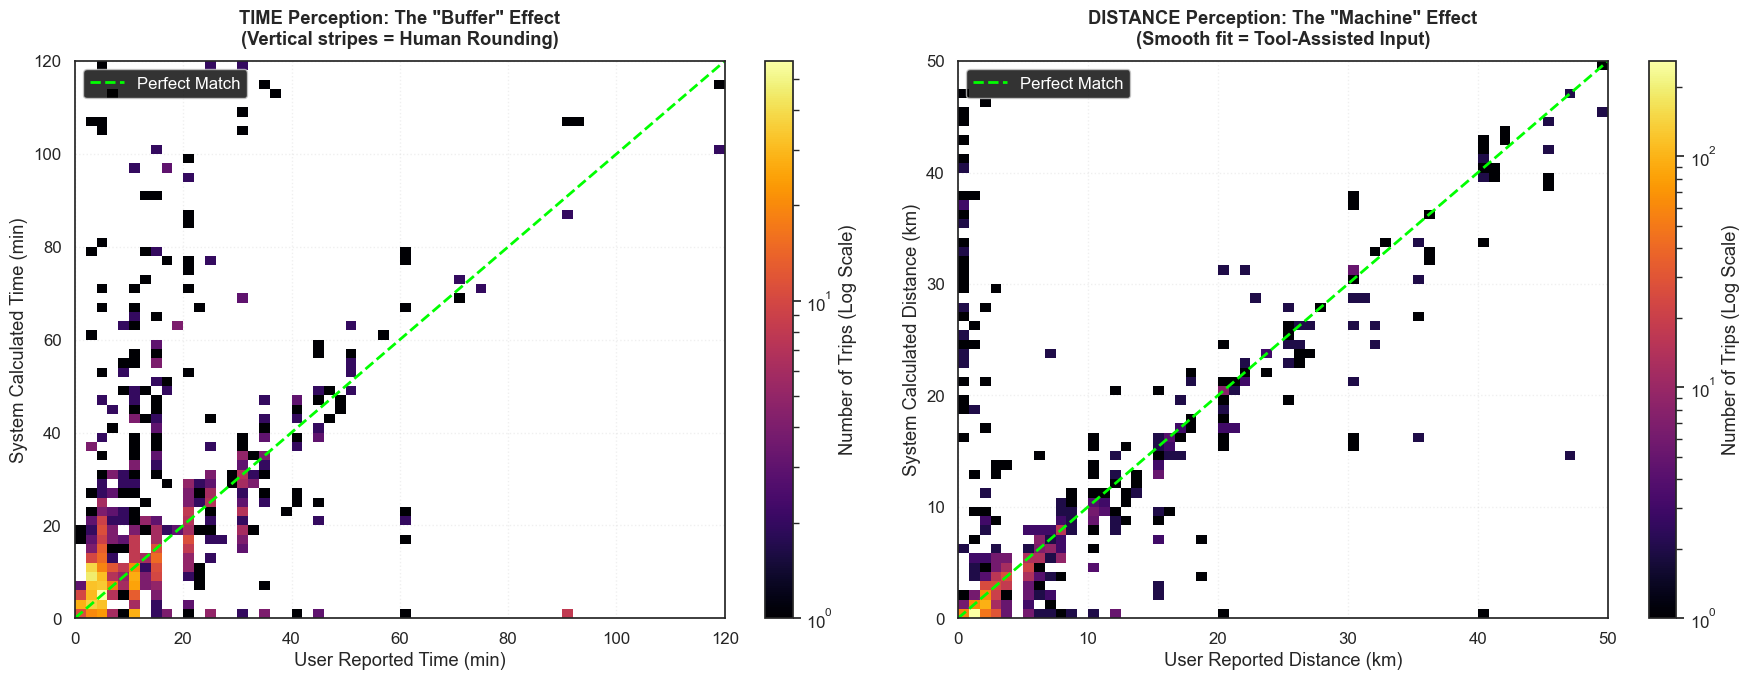

In [24]:
# ==========================================
# IDEA 1: THE REALITY CHECK (Density Matrix)
# ==========================================
sns.set_theme(style="white", font_scale=1.1)


# 1. Filter: Keep rows where EITHER Distance OR Time was corrected
data_viz = RAG[(RAG['corrected_dist_km'].notna()) | (RAG['corrected_time_min'].notna())].copy()

def plot_density_matrix(data, ax, col_user, col_sys, title, max_val, unit_label):
    # Filter view for the plot window to avoid skewing the heatmap
    d = data[(data[col_user] <= max_val) & (data[col_sys] <= max_val)]
    
    # Create the 2D Histogram (Heatmap) with Log Norm
    h = ax.hist2d(
        d[col_user], 
        d[col_sys], 
        bins=60, 
        range=[[0, max_val], [0, max_val]], 
        cmap='inferno', 
        norm=mcolors.LogNorm() 
    )
    
    # 'Perfect Agreement' Line in BRIGHT GREEN
    ax.plot([0, max_val], [0, max_val], color='lime', linestyle='--', linewidth=2, label='Perfect Match')
    
    # Formatting
    ax.set_xlabel(f'User Reported {unit_label}')
    ax.set_ylabel(f'System Calculated {unit_label}')
    ax.set_title(title, fontweight='bold', pad=12)
    
    # Add Colorbar & Legend
    cbar = plt.colorbar(h[3], ax=ax)
    cbar.set_label('Number of Trips (Log Scale)')
    ax.legend(loc='upper left', frameon=True, facecolor='black', labelcolor='white')
    ax.grid(True, linestyle=':', alpha=0.3)

# Initialize Figure
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- PLOT 1: TIME (Minutes) ---
# We drop NaNs just for this specific plot to prevent errors
plot_density_matrix(
    data_viz.dropna(subset=['stagedurationmin_raw', 'corrected_time_min']), 
    axes[0], 
    'stagedurationmin_raw', 'corrected_time_min', 
    'TIME Perception: The "Buffer" Effect\n(Vertical stripes = Human Rounding)', 
    120, 
    'Time (min)'
)

# --- PLOT 2: DISTANCE (Kilometers) ---
plot_density_matrix(
    data_viz.dropna(subset=['stagelength_raw', 'corrected_dist_km']), 
    axes[1], 
    'stagelength_raw', 'corrected_dist_km', 
    'DISTANCE Perception: The "Machine" Effect\n(Smooth fit = Tool-Assisted Input)', 
    50, 
    'Distance (km)'
)

plt.tight_layout()
plt.show()

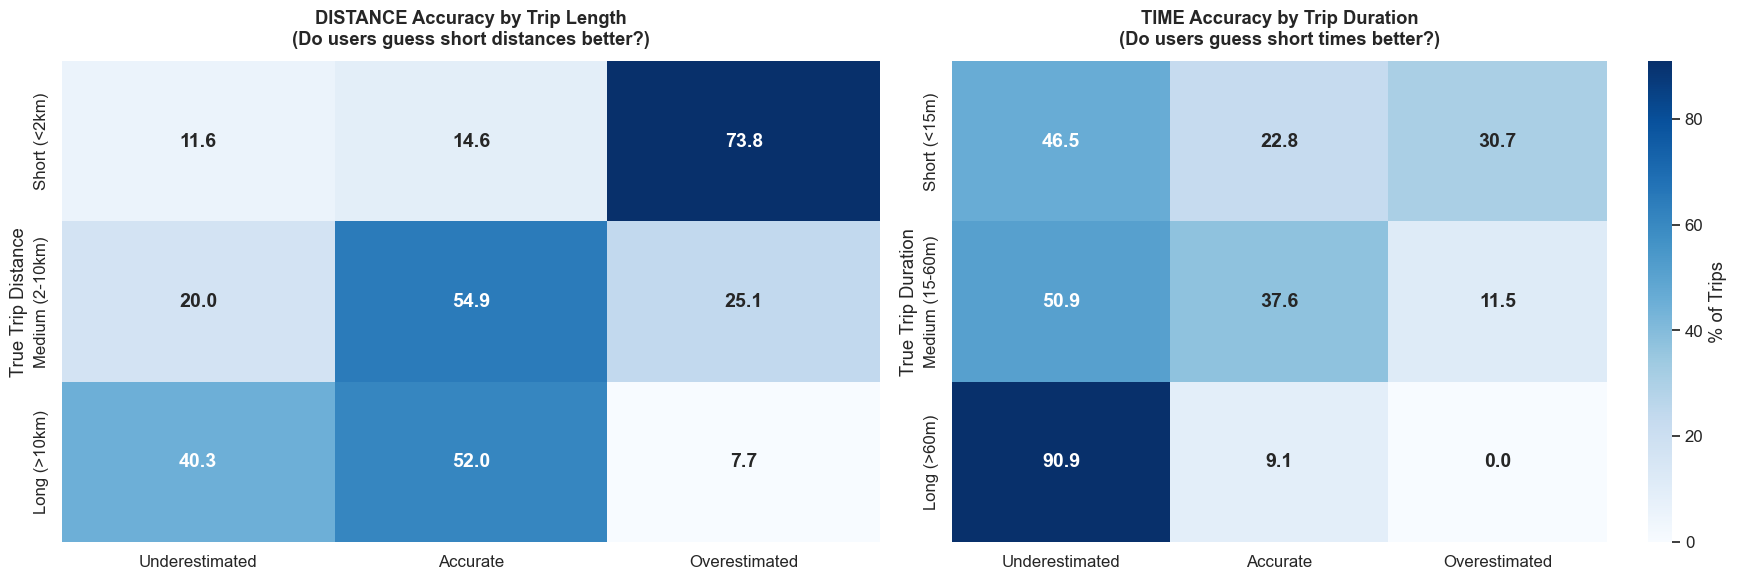

In [25]:
# ==========================================
# IDEA 2: ERROR MAGNITUDE MATRICES
# ==========================================
# "Do users lie more on long trips?"

# 1. PREPARE DISTANCE DATA
# ------------------------
# Drop rows where system distance is 0 to avoid division errors
dist_viz = data_viz[data_viz['corrected_dist_km'] > 0].copy()

# A. Define Trip Size Categories (based on System Truth)
dist_viz['dist_cat'] = pd.cut(
    dist_viz['corrected_dist_km'], 
    bins=[0, 2, 10, 9999], 
    labels=['Short (<2km)', 'Medium (2-10km)', 'Long (>10km)']
)

# B. Calculate % Error: (User - System) / System
dist_viz['pct_error'] = (dist_viz['stagelength_raw'] - dist_viz['corrected_dist_km']) / dist_viz['corrected_dist_km']

# C. Categorize the Error (Tolerance: +/- 20%)
conditions = [
    (dist_viz['pct_error'] < -0.20),
    (dist_viz['pct_error'].between(-0.20, 0.20)),
    (dist_viz['pct_error'] > 0.20)
]
dist_viz['error_type'] = np.select(conditions, ['Underestimated', 'Accurate', 'Overestimated'], default='Accurate')


# 2. PREPARE TIME DATA
# --------------------
# Drop rows where system time is 0
time_viz = data_viz[data_viz['corrected_time_min'] > 0].copy()

# A. Define Duration Categories
time_viz['time_cat'] = pd.cut(
    time_viz['corrected_time_min'],
    bins=[0, 15, 60, 9999],
    labels=['Short (<15m)', 'Medium (15-60m)', 'Long (>60m)']
)

# B. Calculate % Error
time_viz['pct_error'] = (time_viz['stagedurationmin_raw'] - time_viz['corrected_time_min']) / time_viz['corrected_time_min']

# C. Categorize the Error
conditions_time = [
    (time_viz['pct_error'] < -0.20),
    (time_viz['pct_error'].between(-0.20, 0.20)),
    (time_viz['pct_error'] > 0.20)
]
time_viz['error_type'] = np.select(conditions_time, ['Underestimated', 'Accurate', 'Overestimated'], default='Accurate')


# 3. CREATE CROSSTABS (The Matrices)
# ----------------------------------
matrix_dist = pd.crosstab(dist_viz['dist_cat'], dist_viz['error_type'], normalize='index') * 100
matrix_time = pd.crosstab(time_viz['time_cat'], time_viz['error_type'], normalize='index') * 100

# Reorder columns logically
cols_order = ['Underestimated', 'Accurate', 'Overestimated']
matrix_dist = matrix_dist.reindex(columns=cols_order).fillna(0)
matrix_time = matrix_time.reindex(columns=cols_order).fillna(0)


# 4. PLOT
# -------
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Distance Accuracy
sns.heatmap(
    matrix_dist, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=axes[0],
    annot_kws={"size": 14, "weight": "bold"}
)
axes[0].set_title('DISTANCE Accuracy by Trip Length\n(Do users guess short distances better?)', fontweight='bold', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('True Trip Distance')

# Plot 2: Time Accuracy
sns.heatmap(
    matrix_time, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': '% of Trips'}, ax=axes[1],
    annot_kws={"size": 14, "weight": "bold"}
)
axes[1].set_title('TIME Accuracy by Trip Duration\n(Do users guess short times better?)', fontweight='bold', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('True Trip Duration')

plt.tight_layout()
plt.show()

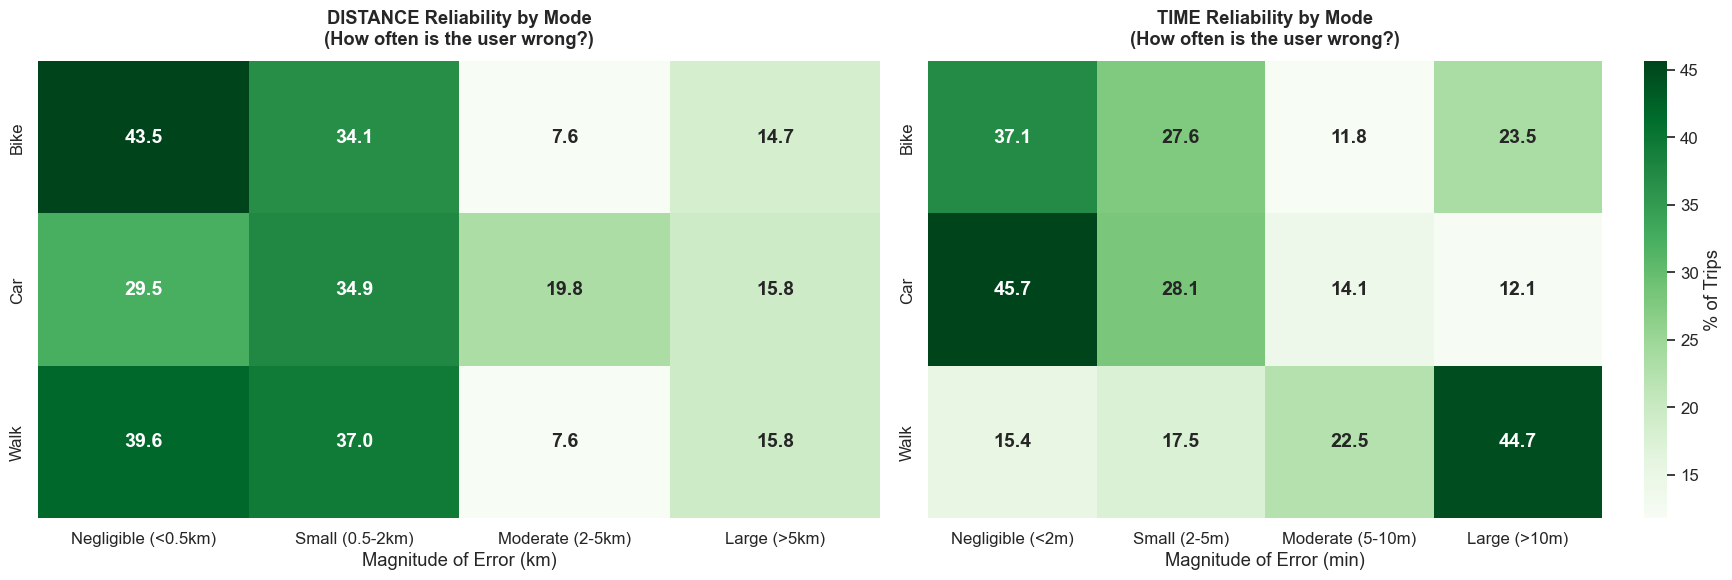

In [26]:
# ==========================================
# IDEA 3: MODE RELIABILITY MATRICES
# ==========================================
# "Which transport mode provides the most trustworthy data?"

# 1. MAP TRANSPORT MODES
# ----------------------
# Ensure we have readable names based on the TU codes
def get_mode_label(code):
    if code == 1: return 'Walk'
    if code == 2: return 'Bike'
    if 3 <= code <= 25: return 'Car'

data_viz['mode_name'] = data_viz['transportmiddel'].apply(get_mode_label)

# Filter out 'Other' to keep the chart clean (focus on main 3 modes)
mode_viz = data_viz[data_viz['mode_name'] != 'Other'].copy()


# 2. PREPARE DISTANCE DATA (Absolute Error)
# -----------------------------------------
# We care about MAGNITUDE of error here (Absolute Difference)
mode_viz['abs_diff_km'] = (mode_viz['stagelength_raw'] - mode_viz['corrected_dist_km']).abs()

# Bin the error magnitude
mode_viz['dist_error_cat'] = pd.cut(
    mode_viz['abs_diff_km'],
    bins=[-0.1, 0.5, 2.0, 5.0, 9999],
    labels=['Negligible (<0.5km)', 'Small (0.5-2km)', 'Moderate (2-5km)', 'Large (>5km)']
)


# 3. PREPARE TIME DATA (Absolute Error)
# -------------------------------------
mode_viz['abs_diff_min'] = (mode_viz['stagedurationmin_raw'] - mode_viz['corrected_time_min']).abs()

# Bin the error magnitude
mode_viz['time_error_cat'] = pd.cut(
    mode_viz['abs_diff_min'],
    bins=[-0.1, 2, 5, 10, 9999],
    labels=['Negligible (<2m)', 'Small (2-5m)', 'Moderate (5-10m)', 'Large (>10m)']
)


# 4. CREATE CROSSTABS
# -------------------
# Normalize='index' gives us the % of trips for that mode
matrix_mode_dist = pd.crosstab(mode_viz['mode_name'], mode_viz['dist_error_cat'], normalize='index') * 100
matrix_mode_time = pd.crosstab(mode_viz['mode_name'], mode_viz['time_error_cat'], normalize='index') * 100


# 5. PLOT
# -------
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Distance Reliability
sns.heatmap(
    matrix_mode_dist, annot=True, fmt='.1f', cmap='Greens', cbar=False, ax=axes[0],
    annot_kws={"size": 14, "weight": "bold"}
)
axes[0].set_title('DISTANCE Reliability by Mode\n(How often is the user wrong?)', fontweight='bold', pad=12)
axes[0].set_xlabel('Magnitude of Error (km)')
axes[0].set_ylabel('')

# Plot 2: Time Reliability
sns.heatmap(
    matrix_mode_time, annot=True, fmt='.1f', cmap='Greens', cbar_kws={'label': '% of Trips'}, ax=axes[1],
    annot_kws={"size": 14, "weight": "bold"}
)
axes[1].set_title('TIME Reliability by Mode\n(How often is the user wrong?)', fontweight='bold', pad=12)
axes[1].set_xlabel('Magnitude of Error (min)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [27]:
show_scrollable(df_corrected)

,SessionId,turid,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,tiladrsogeord,tiladrtext_raw,transportmiddel,stagelength_raw,stagedurationmin_raw,home_lat,home_lon,work_lat,work_lon,start_lat,start_lon,til_lat,til_lon,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,prompt_text,rag_start_address,rag_start_lat,rag_start_lon,rag_start_conf,rag_end_address,rag_end_lat,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction,speed_old,speed_new,valid_before,valid_after
227,347147,2118373,"Kejlstrupvej 15, 8600 Silkeborg",NaN,NaN,NaN,"kejlstrupvej 15, 8600 silkeborg","Nørrevænget 42, 8600","nørrevænget 42, 8600 silkeborg",1.0,1.0,2.0,56.178886,9.554954,NaN,NaN,56.178886,9.554954,56.183815,9.545761,0.789938,0.000000,0.789938,False,True,False,hard_wrong,"Below is an instruction that describes a task,...","Kejlstrupvej 15, 8600 Silkeborg",56.178882,9.554949,1.000000,"Nørrevænget 42, 8600 Silkeborg",56.183812,9.545765,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,1.0,13.0,osrm_recalc,30.000000,4.615385,False,True
466,347271,2118667,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør","Ydunsvej 9, 3000 Helsingør",NaN,"Ydunsvej 9, 3000 Helsingør",NaN,"sundtoldvej 2, 3000 helsingør",2.0,1.0,1.0,56.039003,12.594531,56.041347,12.606025,56.039003,12.594531,56.041347,12.606025,0.760045,0.000000,0.760045,False,False,False,trusted,"Below is an instruction that describes a task,...","Ydunsvej 9, 3000 Helsingør",56.039002,12.594529,1.000000,"Sundtoldvej 2, 3000 Helsingør",56.041346,12.606020,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,1.0,6.0,osrm_recalc,60.000000,10.000000,True,True
469,347271,2118670,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør","Ydunsvej 9, 3000 Helsingør",NaN,"ydunsvej 9, 3000 helsingør","Gefionsvej 47, 3000","gefionsvej 47a, 3000 helsingør",2.0,1.0,1.0,56.039003,12.594531,56.041347,12.606025,56.039003,12.594531,56.039490,12.587380,0.447453,0.000000,0.447453,False,False,False,trusted,"Below is an instruction that describes a task,...","Ydunsvej 9, 3000 Helsingør",56.039002,12.594529,1.000000,"Gefionsvej 47A, 3000 Helsingør",56.039495,12.587382,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.6,3.0,osrm_recalc,60.000000,12.000000,True,True
470,347271,2118671,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør","Ydunsvej 9, 3000 Helsingør","Gefionsvej 47, 3000","gefionsvej 47a, 3000 helsingør",NaN,"ydunsvej 9, 3000 helsingør",2.0,1.0,1.0,56.039003,12.594531,56.041347,12.606025,56.039490,12.587380,56.039003,12.594531,0.447453,0.447453,0.000000,False,False,False,trusted,"Below is an instruction that describes a task,...","Gefionsvej 47A, 3000 Helsingør",56.039495,12.587382,1.000000,"Ydunsvej 9, 3000 Helsingør",56.039002,12.594529,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.7,3.0,osrm_recalc,60.000000,14.000000,True,True
571,347313,2118798,"Ringstedgade 120, 4700 Næstved","Jagtvej 2A, 4700 Næstved","Ringstedgade 120, 4700 Næstved",NaN,"jagtvej 2a, 4700 næstved",NaN,"ringstedgade 120, 4700 næstved",1.0,15.0,35.0,55.246251,11.761771,55.227441,11.781291,55.227441,11.781291,55.246251,11.761771,2.430264,2.430264,0.000000,False,True,False,hard_wrong,"Below is an instruction that describes a task,...","Jagtvej 2A, 4700 Næstved",55.227437,11.781294,1.000000,"Ringstedgade 120, 4700 Næstved",55.246250,11.761763,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,3.1,38.0,osrm_recalc,25.714286,4.894737,False,True
2291,348192,2121202,"Stevnsgade 1, 2200 København N","Hillerød Hospital, Dy

In [28]:
df_corrected_sorted = df_corrected.copy()
df_corrected_sorted = df_corrected_sorted.sort_values('corrected_time_min', ascending=False)

In [29]:
df_corrected_sorted = df_corrected_sorted.drop(columns=['startDayText_raw', 'home_lat', 'home_lon', 'work_lat', 'work_lon','calc_dist_geo', 'flag_coords_bad', 'flag_speed_bad', 'flag_zero_dist','validation_status','prompt_text', 'rag_prompt_text','prompt_text', 'llm_full_response', 'llm_verdict', 'note_correction', 'valid_before', 'valid_after'])

In [30]:
for i, col in enumerate(df_corrected_sorted.columns):
    print(f"{i}: {col}")

0: SessionId
1: homeText_raw
2: workText_raw
3: startstedadrsogeord
4: startTripText_raw
5: turid
6: tiladrsogeord
7: tiladrtext_raw
8: transportmiddel
9: stagelength_raw
10: stagedurationmin_raw
11: start_lat
12: start_lon
13: til_lat
14: til_lon
15: dist_start_home
16: dist_end_home
17: rag_start_address
18: rag_start_lat
19: rag_start_lon
20: rag_start_conf
21: rag_end_address
22: rag_end_lat
23: rag_end_lon
24: rag_end_conf
25: corrected_dist_km
26: corrected_time_min
27: speed_old
28: speed_new


In [31]:
new_order = [0, 5, 1, 2, 3, 4, 17, 20, 6, 7, 21, 24, 8, 9, 25, 10, 26, 27, 28, 11, 12, 18, 19, 13, 14, 22, 23, 15, 16]
new_columns = [df_corrected_sorted.columns[i] for i in new_order]
df_corrected_sorted = df_corrected_sorted[new_columns]

In [32]:
show_scrollable(df_corrected_sorted)

,SessionId,turid,homeText_raw,workText_raw,startstedadrsogeord,startTripText_raw,rag_start_address,rag_start_conf,tiladrsogeord,tiladrtext_raw,rag_end_address,rag_end_conf,transportmiddel,stagelength_raw,corrected_dist_km,stagedurationmin_raw,corrected_time_min,speed_old,speed_new,start_lat,start_lon,rag_start_lat,rag_start_lon,til_lat,til_lon,rag_end_lat,rag_end_lon,dist_start_home,dist_end_home
227,347147,2118373,"Kejlstrupvej 15, 8600 Silkeborg",NaN,NaN,"kejlstrupvej 15, 8600 silkeborg","Kejlstrupvej 15, 8600 Silkeborg",1.000000,"Nørrevænget 42, 8600","nørrevænget 42, 8600 silkeborg","Nørrevænget 42, 8600 Silkeborg",1.000000,1.0,1.0,1.0,2.0,13.0,30.000000,4.615385,56.178886,9.554954,56.178882,9.554949,56.183815,9.545761,56.183812,9.545765,0.000000,0.789938
466,347271,2118667,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør",NaN,"Ydunsvej 9, 3000 Helsingør","Ydunsvej 9, 3000 Helsingør",1.000000,NaN,"sundtoldvej 2, 3000 helsingør","Sundtoldvej 2, 3000 Helsingør",1.000000,2.0,1.0,1.0,1.0,6.0,60.000000,10.000000,56.039003,12.594531,56.039002,12.594529,56.041347,12.606025,56.041346,12.606020,0.000000,0.760045
469,347271,2118670,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør",NaN,"ydunsvej 9, 3000 helsingør","Ydunsvej 9, 3000 Helsingør",1.000000,"Gefionsvej 47, 3000","gefionsvej 47a, 3000 helsingør","Gefionsvej 47A, 3000 Helsingør",1.000000,2.0,1.0,0.6,1.0,3.0,60.000000,12.000000,56.039003,12.594531,56.039002,12.594529,56.039490,12.587380,56.039495,12.587382,0.000000,0.447453
470,347271,2118671,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør","Gefionsvej 47, 3000","gefionsvej 47a, 3000 helsingør","Gefionsvej 47A, 3000 Helsingør",1.000000,NaN,"ydunsvej 9, 3000 helsingør","Ydunsvej 9, 3000 Helsingør",1.000000,2.0,1.0,0.7,1.0,3.0,60.000000,14.000000,56.039490,12.587380,56.039495,12.587382,56.039003,12.594531,56.039002,12.594529,0.447453,0.000000
571,347313,2118798,"Ringstedgade 120, 4700 Næstved","Jagtvej 2A, 4700 Næstved",NaN,"jagtvej 2a, 4700 næstved","Jagtvej 2A, 4700 Næstved",1.000000,NaN,"ringstedgade 120, 4700 næstved","Ringstedgade 120, 4700 Næstved",1.000000,1.0,15.0,3.1,35.0,38.0,25.714286,4.894737,55.227441,11.781291,55.227437,11.781294,55.246251,11.761771,55.246250,11.761763,2.430264,0.000000
2291,348192,2121202,"Stevnsgade 1, 2200 København N","Hillerød Hospital, Dyrehavevej 29, 3400 Hillerød",NaN,"Stevnsgade 1, 2200 København N","Stevnsgade 1, 2200 København N",1.000000,Ølstykke,"ølstykke, 3650","Østerbygdvej 1, 3650 Ølstykke",0.919585,11.0,32.0,33.0,40.0,39.0,48.000000,50.769231,55.693768,12.552831,55.693766,12.552830,0.000000,4.511256,55.769027,12.178773,0.000000,6235.512375
2292,348192,2121203,"Stevnsgade 1, 2200 København N","Hillerød Hospital, Dyrehavevej 29, 3400 Hillerød",Ølstykke,"ølstykke, 3650","Østerbygdvej 1, 3650 Ølstykke",0.919585,Ydermosevej 21,"ydermosevej 21, dalby huse, 3630 jægerspris","Dalby Huse Vej 20, 3630 Jægerspris",0.909781,11.0,20.0,21.5,20.0,23.0,60.000000,56.086957,0.000000,4.511256,55.769027,12.178773,55.810651,11.939983,55.811715,11.946181,6235.512375,40.492751
2486,348314,2121497,"Måløv Hovedgade 146A, 2760 Måløv","Vejlebrovej 45B, 2635 Ishøj",NaN,"måløv hovedgade 146a, 2760 måløv","Måløv Hovedgade 146A, 2760 Måløv",1.000000,"Stationsvej 7, 2760","stationsvej 7, 2760 måløv","Stationsvej 7, 2760 Måløv",1.000000,1.0,2.0,0.8,5.0,11.0,24.000000,4.363636,55.752976,12.310081,55.752979,12.310075,55.748553,12.318696,55.748557,12.318699,0.000996,0.730495
2487,348314,2121498,"Måløv Hovedgade 146A, 2760 Måløv","Vejlebrovej 45B, 2635 Ishøj","Stationsvej 7, 2760","stationsvej 7, 2760 måløv","Stationsvej 7, 2760 Måløv",1.000000,NaN,"måløv hovedgade 146a, 2760 måløv","Måløv Hovedgade 146A, 2760 Måløv",1.000000,1.0,2.0,0.8,5.0,11.0,24.000000,4.363636,55.748553,12.318696,55.748557,12.318699,55.752976,12.310081,55.752979,12.310075,0.730495,0.000996
2799,348483,2121930,"Kongefolden 65, Skanderborg Bakker, 8660 Skand...","Bogøvej 15, 8382 Hinnerup",NaN,"Kongefolden 65, Ska